In [0]:
!pip install -U -q PyDrive

In [0]:
# import data from Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
# software, math libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd
import cv2
import pickle

In [0]:


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 2. Import data from google drive (id is from google drive shareable link)

# Get training data
download = drive.CreateFile({'id': '1BEp0SzrCinaDP3Icb8PkTQge5c1ymS94'})
download.GetContentFile('train_images.npy')
download = drive.CreateFile({'id': '1pKyWJtNEu3O1XukE75iOHteLHRVCDjPG'})
download.GetContentFile('train_labels.csv')

# Get test data
download = drive.CreateFile({'id': '1BEp0SzrCinaDP3Icb8PkTQge5c1ymS94'})
download.GetContentFile('test_images.npy')

In [6]:
!pwd
!ls ../..

/content
bin	    content  etc   lib64  opt	run   sys    usr
boot	    datalab  home  media  proc	sbin  tmp    var
colabtools  dev      lib   mnt	  root	srv   tools


In [0]:
#! CHANGE THIS!!

images_train = np.load('./train_images.npy', encoding='latin1')
train_labels = pd.read_csv('./train_labels.csv')

label_list = train_labels.Category.unique().tolist()
label_dict = {label:i  for i,label in enumerate(label_list)}
train_labels['Category_num'] = train_labels.Category.apply(lambda x: label_dict[x])

train_df = pd.DataFrame(images_train, columns = ['Id', 'img'])
train_df = pd.merge(train_df, train_labels, on = 'Id')

images_test = np.load('./test_images.npy', encoding='latin1')
test_df = pd.DataFrame(images_test, columns = ['Id', 'img'])

#print(train_df.head(n=5))

training_vectors = np.array(train_df['img'].tolist())

# Split into training and validation
validation_vectors = training_vectors[9000:]
validation_labels = train_labels['Category_num'][9000:]
training_vectors = training_vectors[:9000]
training_labels = train_labels['Category_num'][:9000]

testing_vectors = np.array(test_df['img'].tolist())

In [8]:
from keras.utils import to_categorical
#one-hot encode target column
train_targets = to_categorical(training_labels)
validation_targets = to_categorical(validation_labels)
train_targets[0]

Using TensorFlow backend.


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [9]:
from google.colab import drive

drive.mount('/content/drive/')
DATA_PATH = "/content/drive/My Drive/kaggle_hw4"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [10]:
# RUN THIS TO LOAD THE PICKLE!
import os
DATA_PATH = "/content/drive/My Drive/kaggle_hw4"
with open(os.path.join(DATA_PATH, 'train_data_preproc.pickle'), 'rb') as jar:
  train_data = pickle.load(jar)
  
with open(os.path.join(DATA_PATH, 'valid_data_preproc.pickle'), 'rb') as jar:
  valid_data = pickle.load(jar)

print(len(train_data))



9000


(9000, 100, 100)
(9000, 100, 100)
(1000, 100, 100)
(1000, 100, 100)


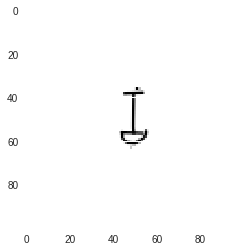

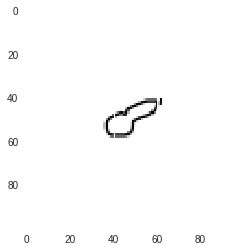

In [11]:
# try plotting the pickled



train_data = np.array(train_data)
print(train_data.shape)

print(train_data.shape)



valid_data = np.array(valid_data)
print(valid_data.shape)

print(valid_data.shape)

plt.figure()
plt.imshow(train_data[0].reshape(100, 100))
plt.figure()
plt.imshow(valid_data[0].reshape(100, 100))

In [12]:
# reshape to n by 100 by 100 by 3 for VGG
#train_data = train_data.reshape(train_data.shape + (1,))
#valid_data = valid_data.reshape(valid_data.shape + (1,))


vgg_train_data = np.stack((train_data,train_data,train_data), axis = -1)
print(vgg_train_data.shape)
#vgg_train_data= vgg_train_data.reshape(9000, 100, 100, 3)
print(vgg_train_data.shape)


vgg_validation_data = np.stack((valid_data, valid_data, valid_data), axis = -1)
#vgg_validation_data = vgg_validation_data.reshape(1000, 100, 100, 3)
print(vgg_validation_data.shape)

(9000, 100, 100, 3)
(9000, 100, 100, 3)
(1000, 100, 100, 3)


In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from keras.optimizers import SGD


def create_model():

  #Get back the convolutional part of a VGG network trained on ImageNet
  model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
  model_vgg16_conv.summary()

  #Create your own input format (here 3x100x100)
  input = Input(shape=(100,100, 3),name = 'image_input')

  #Use the generated model 
  output_vgg16_conv = model_vgg16_conv(input)

  #Add the fully-connected layers 
  x = Flatten(name='flatten')(output_vgg16_conv)
  x = Dense(4096, activation='relu', name='fc1')(x)
  x = Dense(4096, activation='relu', name='fc2')(x)
  x = Dense(31, activation='softmax', name='predictions')(x)

  #Create your own model 
  my_model = Model(input=input, output=x)

  #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
  my_model.summary()


  sgd = SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
  my_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return my_model


#Then training with your data ! 
#my_model.fit(x=vgg_train_data, y=train_targets, batch_size=100, epochs=20, 
#             verbose=1, callbacks=None, validation_split=0.1,
#             validation_data=None,
#             shuffle=True, class_weight=None, sample_weight=None, 
#             initial_epoch=0, steps_per_epoch=None, validation_steps=None)
  

In [20]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

model = None
model = create_model()
kfold_splits = 10
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state = 1)


print("training_labels", training_labels.shape)

# MUST use training_labels, one num to indiate category
# one hot incode in the fit itself
for index, (train_indices, val_indices) in enumerate(skf.split(vgg_train_data, training_labels)):
  print("Training on fold " + str(index+1) + "/10...")
  # Generate batches from indices
  xtrain, xval = vgg_train_data[train_indices], vgg_train_data[val_indices]
  ytrain, yval = training_labels[train_indices], training_labels[val_indices]
  
  ytrain = to_categorical(ytrain)
  yval = to_categorical(yval)
  
  model.fit(xtrain, ytrain, validation_data=(xval, yval), batch_size=100, epochs=10)

    
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


Train on 8084 samples, validate on 916 samples
Epoch 1/10
8084/8084 [==============================] - 55s 7ms/step - loss: 3.1041 - acc: 0.1676 - val_loss: 2.4589 - val_acc: 0.3090
Epoch 2/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.9993 - acc: 0.4254 - val_loss: 1.7955 - val_acc: 0.4880
Epoch 3/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.5780 - acc: 0.5464 - val_loss: 1.5752 - val_acc: 0.5546
Epoch 4/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.3795 - acc: 0.6003 - val_loss: 1.5388 - val_acc: 0.5808
Epoch 5/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.2401 - acc: 0.6414 - val_loss: 1.4253 - val_acc: 0.5873
Epoch 6/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.1412 - acc: 0.6697 - val_loss: 1.3667 - val_acc: 0.6157
Epoch 7/10
8084/8084 [==============================] - 54s 7ms/step - loss: 1.0470 - acc: 0.6914 - val_loss: 1.3328 - val_acc: 0.6310
Epoch 8/

In [26]:
import pickle
from google.colab import drive

drive.mount('/content/drive/')
DATA_PATH = "/content/drive/My Drive/kaggle_hw4"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:


model.save(os.path.join(DATA_PATH, 'vgg_crossval.h5'))


In [28]:
!pwd
print(DATA_PATH)

/content
/content/drive/My Drive/kaggle_hw4


In [29]:
import keras
saved_model = keras.models.load_model(os.path.join(DATA_PATH , 'vgg_crossval.h5'))
score = saved_model.evaluate(x = vgg_validation_data, y= validation_targets)
print("eval from save model", score)


1000/1000 [==============================] - 3s 3ms/step
eval from save model [3.039840970993042, 0.659]


In [31]:
score = model.evaluate(x = vgg_validation_data, y= validation_targets)
print("eval from current trained model", score)


1000/1000 [==============================] - 3s 3ms/step
eval from current trained model [3.039840970993042, 0.659]


In [0]:
# load pickle from the test data preprocessed
with open(os.path.join(DATA_PATH, "vgg_test_data_preproc.pickle"), 'rb') as jar:
  vgg_test_data = pickle.load(jar)  
 

In [0]:
test_predicted = saved_model.predict(vgg_test_data)



In [0]:
# pickle the results
with open(os.path.join(DATA_PATH, "test_predicted_cross_val.pickle"), 'wb') as jar:
    pickle.dump(test_predicted, jar, protocol=pickle.HIGHEST_PROTOCOL)